src= https://www.kaggle.com/datasets/sandeep1080/used-car-sales/code

25 columns
title : used-car-sales

In [132]:
!pip install pip==23.2.1 setuptools==65.5.1

In [133]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [134]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "vehicles.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/vehicles.csv


In [135]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [136]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [137]:
df.shape

(426880, 26)

In [138]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [140]:
df.duplicated().sum()

0

In [141]:
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

In [142]:
# Drop column where all values are null
df.drop(columns=['county'], inplace=True)


In [143]:
# Fill with mode for categorical, median/mean for numerical
df['year'].fillna(df['year'].median(), inplace=True)
df['fuel'].fillna(df['fuel'].mode()[0], inplace=True)
df['odometer'].fillna(df['odometer'].median(), inplace=True)


In [144]:
threshold = 0.5
df = df.loc[:, df.isnull().mean() < threshold]

In [145]:
# Fill common categorical columns with mode
for col in ['manufacturer', 'model', 'title_status', 'transmission', 'drive']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill remaining high-missing categorical with "unknown"
for col in ['condition', 'cylinders', 'type', 'paint_color']:
    df[col].fillna('unknown', inplace=True)

# Drop VIN if not used in modeling
df.drop(columns=['VIN'], inplace=True)

# Drop rows with minor missing (image_url, description, posting_date, lat/long)
df.dropna(subset=['image_url', 'description', 'posting_date', 'lat', 'long'], inplace=True)


In [146]:
df.isnull().sum()

id              0
url             0
region          0
region_url      0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
image_url       0
description     0
state           0
lat             0
long            0
posting_date    0
dtype: int64

In [147]:
df.shape

(420329, 23)

In [148]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'drive', 'type', 'paint_color', 'image_url',
       'description', 'state', 'lat', 'long', 'posting_date'],
      dtype='object')

In [149]:
df.drop(columns=['id', 'url', 'region_url', 'image_url','description','posting_date'], inplace=True)

In [150]:
df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,33.786500,-84.445400
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,33.786500,-84.445400
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,unknown,diesel,4174.0,clean,other,4wd,hatchback,white,wy,33.779214,-84.411811
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,33.786500,-84.445400
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,unknown,gas,22716.0,clean,other,rwd,coupe,unknown,wy,33.779214,-84.411811


In [151]:
df['year'] = df['year'].astype(int)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420329 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        420329 non-null  object 
 1   price         420329 non-null  int64  
 2   year          420329 non-null  int64  
 3   manufacturer  420329 non-null  object 
 4   model         420329 non-null  object 
 5   condition     420329 non-null  object 
 6   cylinders     420329 non-null  object 
 7   fuel          420329 non-null  object 
 8   odometer      420329 non-null  float64
 9   title_status  420329 non-null  object 
 10  transmission  420329 non-null  object 
 11  drive         420329 non-null  object 
 12  type          420329 non-null  object 
 13  paint_color   420329 non-null  object 
 14  state         420329 non-null  object 
 15  lat           420329 non-null  float64
 16  long          420329 non-null  float64
dtypes: float64(3), int64(2), object(12)
memory usag

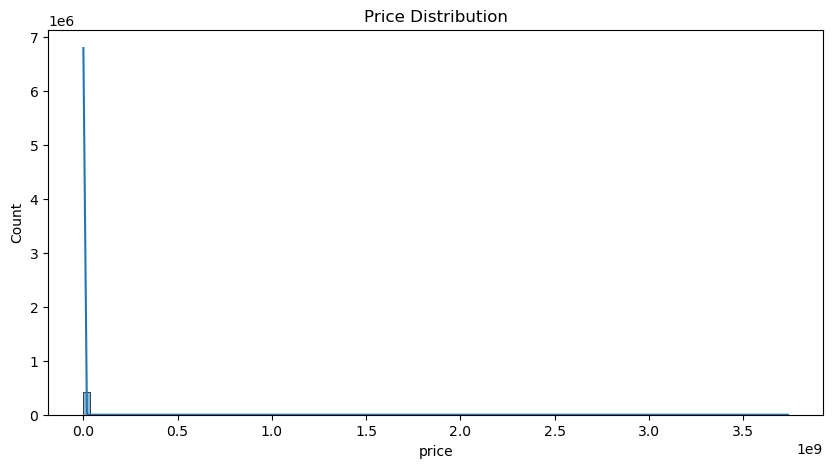

count    4.203290e+05
mean     7.619384e+04
std      1.227685e+07
min      0.000000e+00
25%      5.990000e+03
50%      1.398800e+04
75%      2.659000e+04
max      3.736929e+09
Name: price, dtype: float64


In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution")
plt.show()

print(df['price'].describe())


In [154]:
df = df[(df['price'] > 0) & (df['price'] <= 50000)]

In [155]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


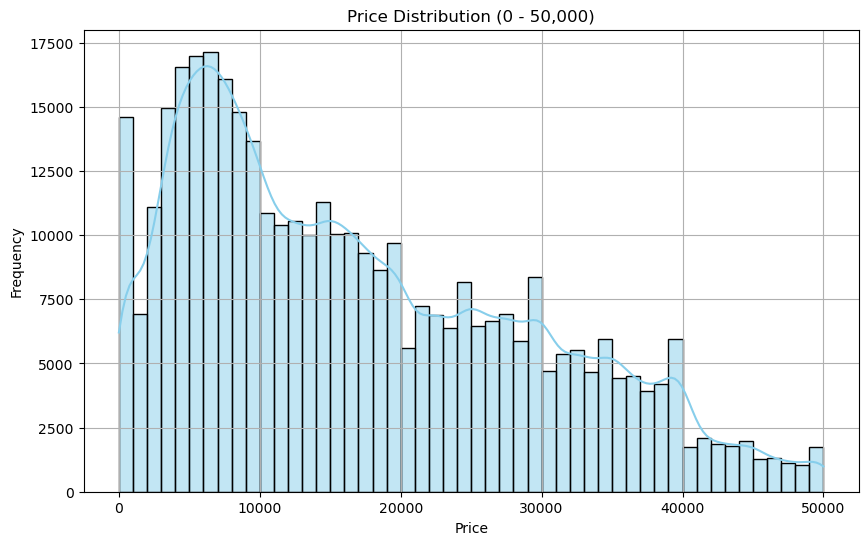

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution (0 - 50,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


count    377598.000000
mean      17254.099055
std       12196.552707
min           1.000000
25%        6995.000000
50%       14900.000000
75%       25995.000000
max       50000.000000
Name: price, dtype: float64


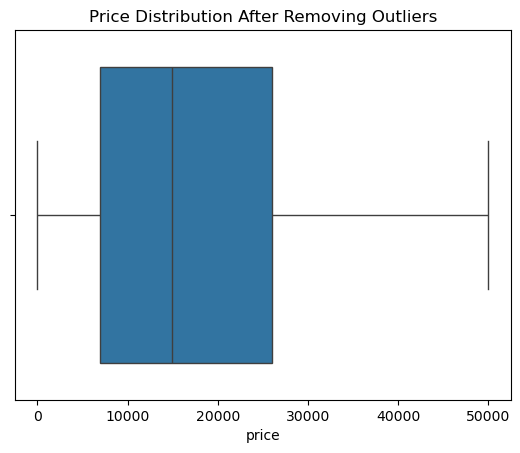

In [157]:
print(df['price'].describe())
sns.boxplot(x=df['price'])
plt.title("Price Distribution After Removing Outliers")
plt.show()


In [158]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

print("✅ Preprocessing complete. Here's a preview:")
print(df.head())


✅ Preprocessing complete. Here's a preview:
    region  price  year  manufacturer  model  condition  cylinders  fuel  \
27      16  33590  2014            14  22284          2          6     2   
28      16  22590  2010             7  22581          2          6     2   
29      16  39590  2020             7  22623          2          6     2   
30      16  30990  2017            39  25387          2          6     2   
31      16  15000  2013            13  13318          0          5     2   

    odometer  title_status  transmission  drive  type  paint_color  state  \
27   57923.0             0             2      0     8           11      1   
28   71229.0             0             2      0     8            1      1   
29   19160.0             0             2      0     8            8      1   
30   41124.0             0             2      0     8            8      1   
31  128000.0             0             0      2    10            0      1   

       lat     long  
27  32.590 -85

In [159]:
# Separate target and features
y = df['price']
X = df.drop(columns=['price'])

print("✅ Target and features are ready!")
print("🎯 y (target):", y.name)
print("🧠 X shape:", X.shape)


✅ Target and features are ready!
🎯 y (target): price
🧠 X shape: (377598, 16)


In [160]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split complete!")
print("🧪 X_train shape:", X_train.shape)
print("🧪 X_test shape :", X_test.shape)
print("🎯 y_train shape:", y_train.shape)
print("🎯 y_test shape :", y_test.shape)


✅ Data split complete!
🧪 X_train shape: (302078, 16)
🧪 X_test shape : (75520, 16)
🎯 y_train shape: (302078,)
🎯 y_test shape : (75520,)


# FInd Algorithem = LightGBM 

In [189]:
import time
import random
import math
import lightgbm as lgb  # Changed from catboost to lightgbm
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [190]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm") 

In [191]:
# DEAP setup for GA (unchanged)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using LightGBM"""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'verbosity': -1,  # -1 means silent
        'seed': 42
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train.iloc[:, selected_indices], label=y_train)
    test_data = lgb.Dataset(X_test.iloc[:, selected_indices], label=y_test, reference=train_data)

    # Train model - note different parameter names
    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, test_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(0)  # Replaces verbose_eval
        ]
    )

    return mean_squared_error(y_test, model.predict(X_test.iloc[:, selected_indices]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## 2. CUSTOM WHALE OPTIMIZATION ALGORITHM

In [192]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm"""
    def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # a decreases linearly from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # a2 decreases linearly from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1  # Spiral constant
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        # Search for prey
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    # Bubble-net attacking
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate new solution
                fitness[i] = self.func(whales[i])

                # Update best
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness

## 3. SQUID GAME OPTIMIZER (SGO) IMPLEMENTATION

In [193]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and elimination rounds."""
    def __init__(self, func, dim, lb, ub, n_players=30, max_games=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players with roles (0=defensive, 1=offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])
        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.2 + (0.5 * game / self.max_games)  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    # Aggressive move toward best player with momentum
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    # Local search with adaptive step size
                    step = np.random.normal(0, 0.5*(1-game/self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # Role adaptation
                if random.random() < 0.1:  # 10% chance to switch roles
                    roles[i] = 1 - roles[i]

            # Evaluate and apply elimination
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                # Survival condition
                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1*best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness

In [194]:
class PSH_Hyptrite:
    """Fixed implementation with bounds checking"""
    def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - iter/self.max_iter)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 3)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

## ALGORITHM IMPLEMENTATIONS (ONE-BY-ONE)

In [195]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 30")
        print(f"- Generations: 20")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Changed to LightGBM

    # 2. Setup evolutionary toolbox 
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                    toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))  # Now uses LightGBM
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 3. Initialize population
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(20):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        if gen % 5 == 0 or gen == 19:
            print(f"Gen {gen+1:02d}/20 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence (LightGBM)')  # Updated title
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [196]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 30 particles")
        print(f"- Iterations: 20")
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Changed to LightGBM

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Now uses LightGBM

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 30 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=30,
        maxiter=20,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence (LightGBM)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [197]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 30 whales")
        print(f"- Max iterations: 20")
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Changed to LightGBM

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Now uses LightGBM
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)
                a2 = -1 + iter * (-1 / self.max_iter)

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    whales[i] = np.clip(whales[i], self.lb, self.ub)
                    fitness[i] = self.func(whales[i])

                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence (LightGBM)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }

In [198]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 30 (15 offensive, 15 defensive)")
        print(f"- Max games: 20")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using LightGBM \n")  # Changed from XGBoost to CatBoost

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Now uses CatBoost

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=30,
        max_games=20
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results (unchanged)
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis (unchanged except plot title)
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence (LightGBM )')  # Updated title
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [199]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization with LightGBM specification
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 30")
        print(f"- Max iterations: 20") 
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Updated to LightGBM

    # 2. Setup bounds and tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. LightGBM evaluation function
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # LightGBM evaluation
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite optimizer (unchanged structure)
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3

        def hypersphere_sampling(self, center, radius, n_samples):
            """Efficient hypersphere sampling with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Prevent division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize with boundary checking
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                radius = initial_radius * (1 - iter/self.max_iter)  # Linear decay
                
                # Vectorized hypersphere sampling
                new_points = np.vstack([self.hypersphere_sampling(p, radius, self.hs_samples) 
                                    for p in points])
                
                # Parallel evaluation
                new_fitness = np.array([self.func(p) for p in new_points])

                # Elite selection
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]
                
                # Update best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Progress reporting
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                        end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Execute optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-processing with min 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)

    # 7. Results reporting
    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Enhanced visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence (LightGBM)')  # Cleaned title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [200]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb  # Changed from catboost to lightgbm
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name} with LightGBM...")  # Added LightGBM specification
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms using LightGBM"""
    plt.figure(figsize=(15, 10))
    plt.suptitle('Algorithm Comparison (LightGBM Evaluation)', y=1.02)  # Added main title

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'steelblue' for name in names]  # Improved colors
    bars = plt.bar(names, mses, color=colors)
    plt.title('Model Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    bars = plt.bar(names, times, color=colors)
    plt.title('Computational Efficiency')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    bars = plt.bar(names, feature_counts, color=colors)
    plt.title('Feature Selection Sparsity')
    plt.ylabel('Number of Selected Features')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            linewidth = 3 if name == best_algo_name else 1.5
            linestyle = '-' if name == best_algo_name else '--'
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=linewidth,
                    linestyle=linestyle)
    plt.title('Convergence Patterns')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Enhanced summary report
    print("\n" + "="*60)
    print("=== FINAL FEATURE SELECTION RESULTS USING LightGBM ===")
    print("="*60)
    
    # Best algorithm summary
    print(f"\n🏆 BEST ALGORITHM: {best_algo_name.upper()}")
    print(f"   • MSE: {results[best_algo_name]['mse']:.6f}")
    print(f"   • Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"   • Features: {len(results[best_algo_name]['features'])}/{X_train.shape[1]} "
          f"({100*(1 - len(results[best_algo_name]['features'])/X_train.shape[1]):.1f}% reduction)")
    
    # Full comparison table
    print("\n📊 COMPARISON TABLE:")
    print(f"{'Algorithm':<30}{'MSE':<15}{'Time (s)':<15}{'Features':<15}")
    print("-"*75)
    for name in sorted(results.keys(), key=lambda x: results[x]['mse']):
        print(f"{name:<30}{results[name]['mse']:<15.6f}{results[name]['time']:<15.2f}"
              f"{len(results[name]['features']):<15}")

    # Selected features
    print("\n🔍 SELECTED FEATURES:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")
    
    print("\n💡 Tip: Consider feature importance from LightGBM for further analysis")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm with LightGBM...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 30
- Generations: 20
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 16 features
- Target: Minimize MSE using LightGBM

[Evolution Progress]
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[95]	training's l2: 7.20153e+07	valid_1's l2: 7.27093e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 4.41144e+07	valid_1's l2: 4.4831e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 7.21764e+07	valid_1's l2: 7.26604e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 4.20825e+07	valid_1's l2: 4.2763e+07
Training until validation scores don't improve for 10 roun

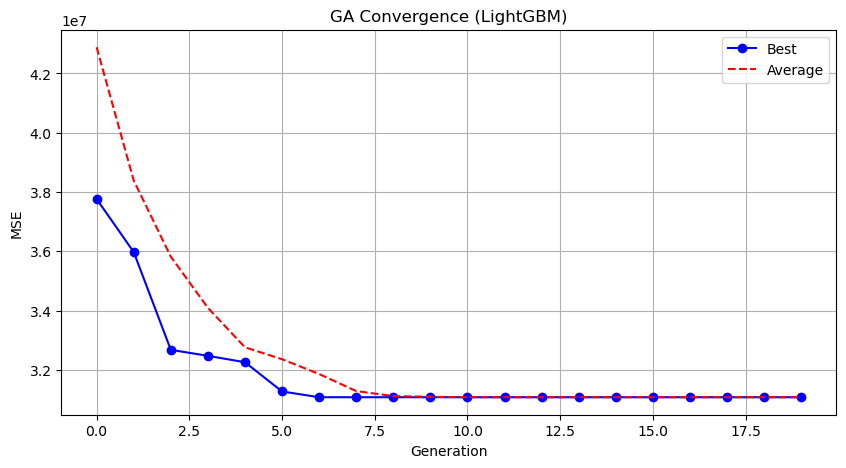

Genetic Algorithm completed successfully with MSE: 31079344.3968

Running Particle Swarm Optimization with LightGBM...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 16 features
- Target: Minimize MSE using LightGBM

[Optimization Progress]
No constraints given.
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 5.64409e+07	valid_1's l2: 5.64867e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 5.16823e+07	valid_1's l2: 5.27818e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.50079e+07	valid_1's l2: 3.5553e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iter

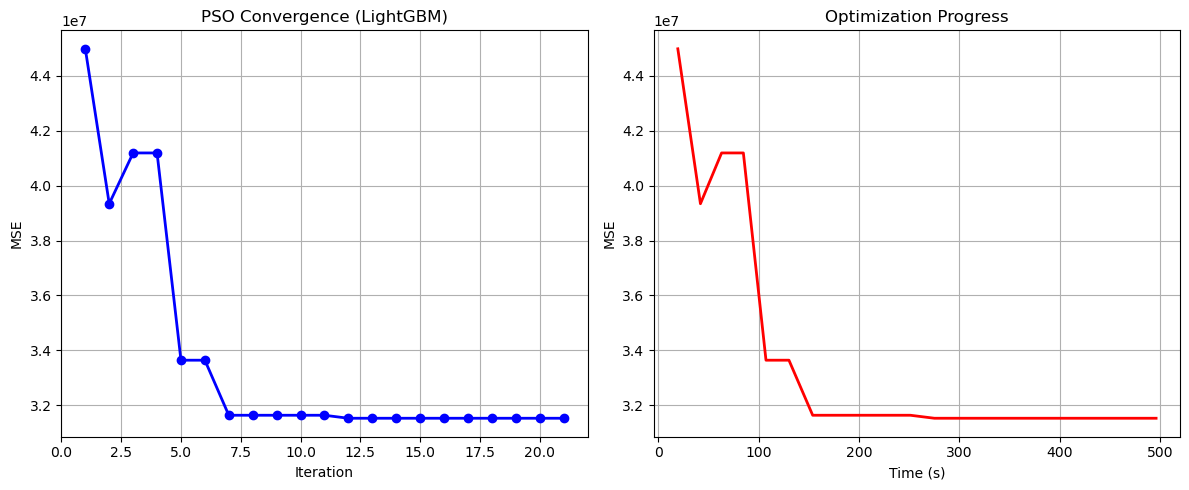

Particle Swarm Optimization completed successfully with MSE: 31530543.6550

Running Whale Optimization with LightGBM...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 30 whales
- Max iterations: 20
- Spiral coefficient (b): 1.0
- Search space: 16 features
- Target: Minimize MSE using LightGBM

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 5.84752e+07	valid_1's l2: 5.90065e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.85925e+07	valid_1's l2: 3.92886e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 7.73001e+07	valid_1's l2: 7.79807e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 4.59541e+07	valid_1's l2: 4.64424e+07
Training u

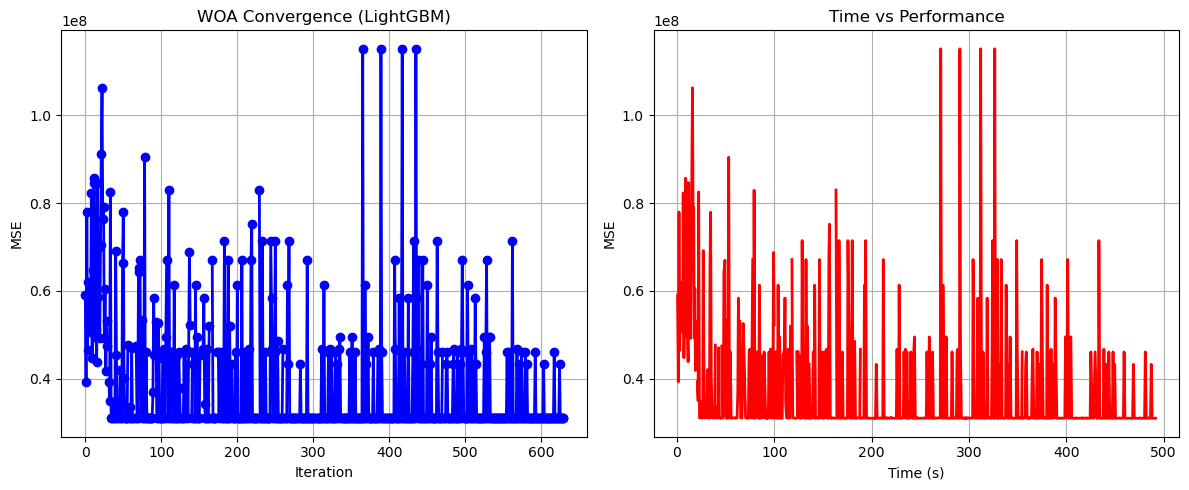

Whale Optimization completed successfully with MSE: 31001711.4920

Running Squid Game Optimizer with LightGBM...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 30 (15 offensive, 15 defensive)
- Max games: 20
- Search space: 16 features
- Target: Minimize MSE using LightGBM 

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 5.25825e+07	valid_1's l2: 5.27717e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.75124e+07	valid_1's l2: 3.81439e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 9.80997e+07	valid_1's l2: 9.75902e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 7.2525e+07	valid_1's l2: 7.32714e+07
Training until validation scores do

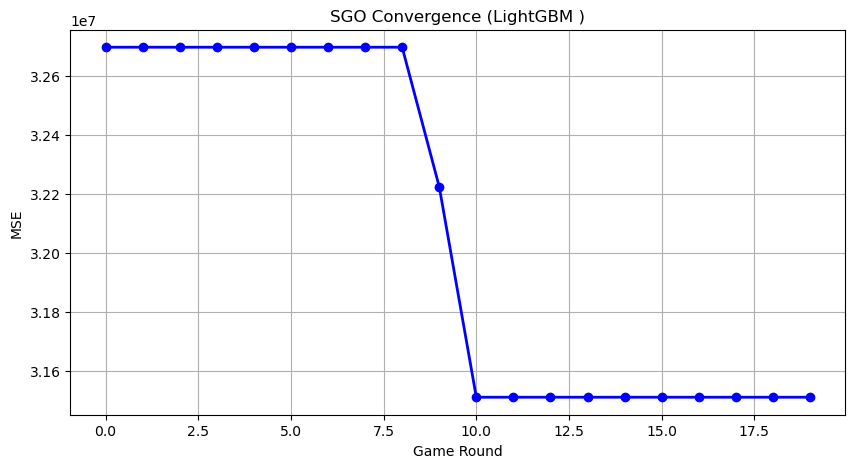

Squid Game Optimizer completed successfully with MSE: 31511215.0579

Running PSH-Hyptrite with LightGBM...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 16 features
- Target: Minimize MSE using LightGBM

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.97422e+07	valid_1's l2: 4.0294e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 8.57526e+07	valid_1's l2: 8.58846e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 7.89049e+07	valid_1's l2: 7.96293e+07
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 3.97605e+07	valid_1's l2: 4.071

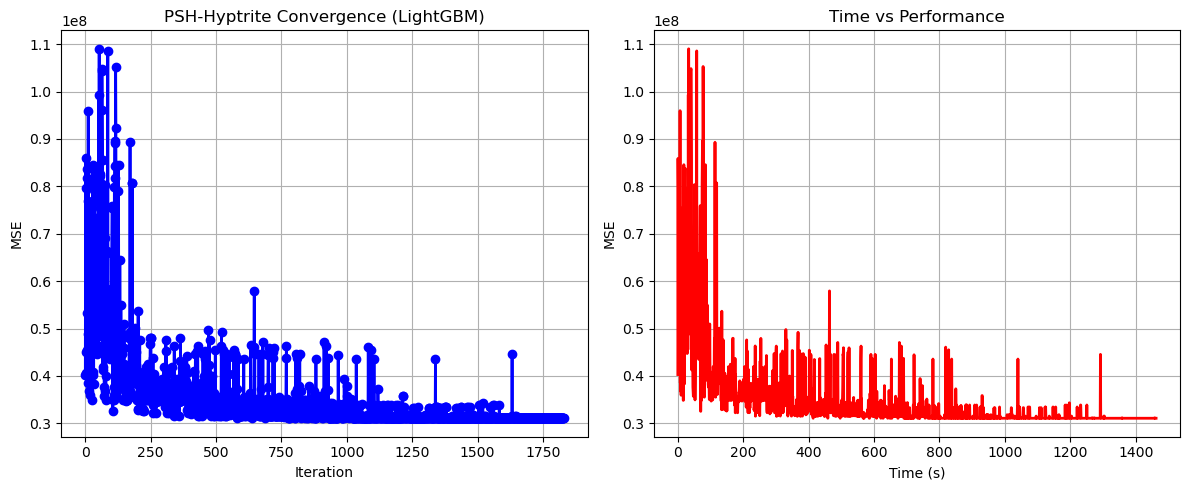

PSH-Hyptrite completed successfully with MSE: 31079344.3968


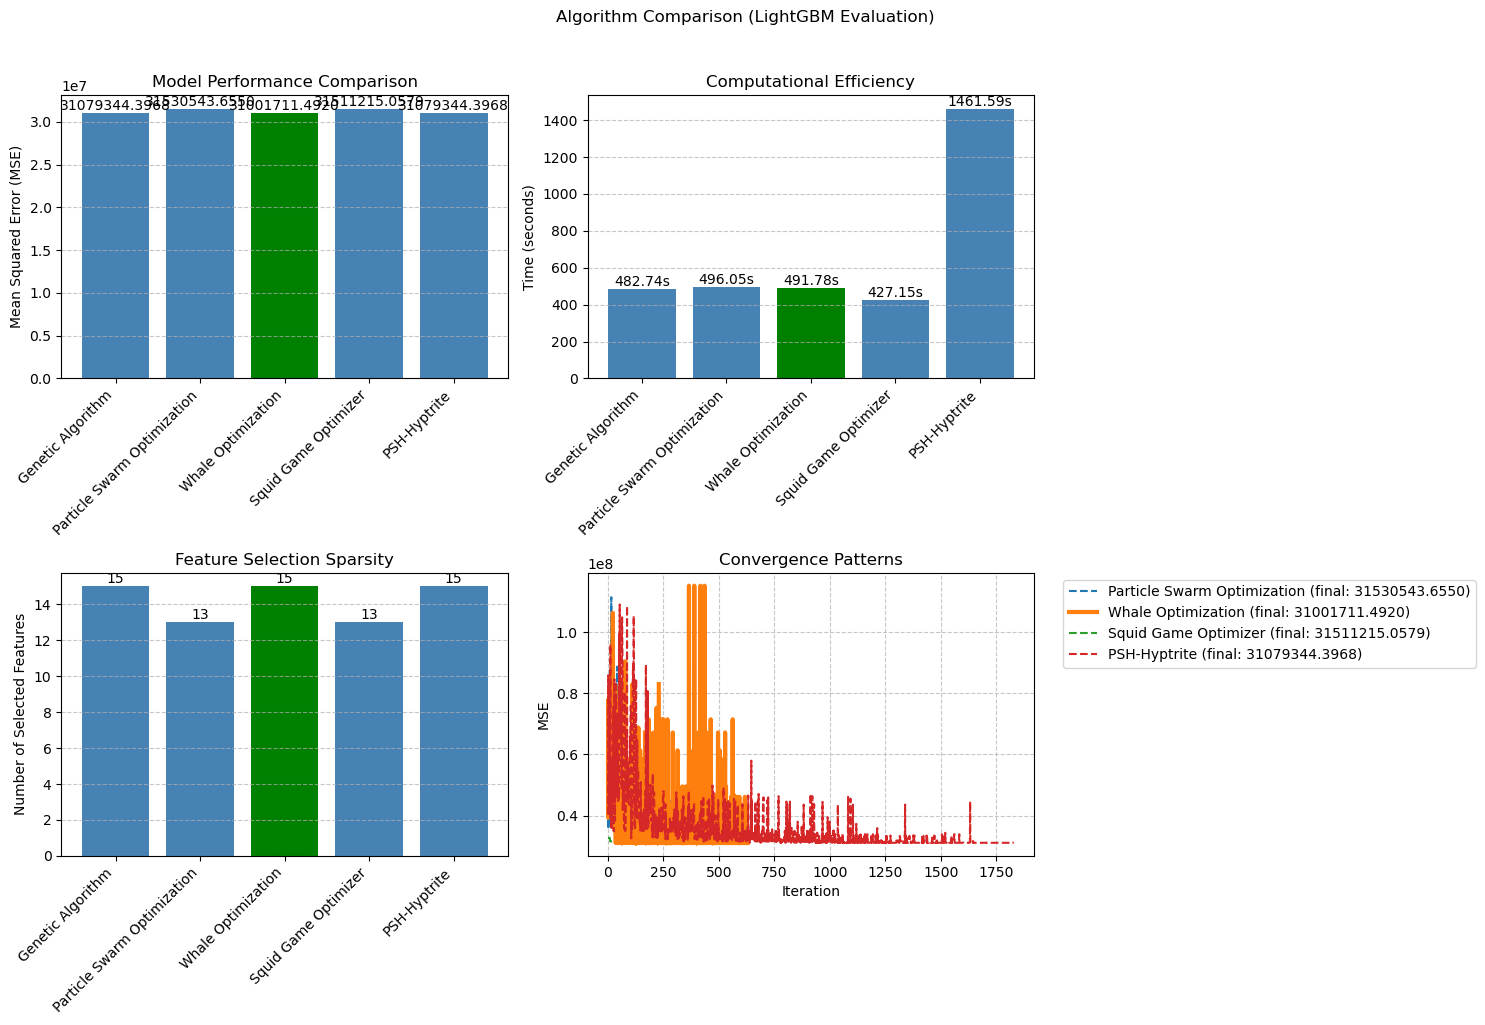


=== FINAL FEATURE SELECTION RESULTS USING LightGBM ===

🏆 BEST ALGORITHM: WHALE OPTIMIZATION
   • MSE: 31001711.492033
   • Time: 491.78 seconds
   • Features: 15/16 (6.2% reduction)

📊 COMPARISON TABLE:
Algorithm                     MSE            Time (s)       Features       
---------------------------------------------------------------------------
Whale Optimization            31001711.492033491.78         15             
Genetic Algorithm             31079344.396795482.74         15             
PSH-Hyptrite                  31079344.3967951461.59        15             
Squid Game Optimizer          31511215.057878427.15         13             
Particle Swarm Optimization   31530543.654983496.05         13             

🔍 SELECTED FEATURES:
1. region
2. year
3. manufacturer
4. model
5. condition
6. cylinders
7. fuel
8. odometer
9. title_status
10. transmission
11. drive
12. type
13. paint_color
14. lat
15. long

💡 Tip: Consider feature importance from LightGBM for further analy

In [201]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)